In [8]:
%pylab inline
import pandas as pd
import emcee
import time
import os
import sys
import corner
from astropy.constants import au,h,pc,c
import glob
import pickle
import pdb as pdb
from slabspec import *
from flux_calculator import *
from slab_fitter import * 
from scipy.optimize import minimize
import random
from mcmc import rot_mcmc, loglikelihood
from helpers import *
from astropy.table import table

Populating the interactive namespace from numpy and matplotlib


/Users/adammoses/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['convolve', 'table', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Running on synthetic data set

In [ ]:
def sangle_to_area(omega, distance):
    return omega*(distance*3.1e16)**2


distance=140


result = np.array([0.,0.,0.,0.,0.,0.,0.,0.,0.,0.])

# Set random variables
logn = np.random.random()*4+20
temp = np.random.normal(750, 100)
logomega = np.random.random()*9-21

result[0] = round(logn,4)
result[1] = round(temp,4)
result[2] = round(logomega,4)
result[9] = round(distance,4)


params = np.array([logn, temp, logomega, distance])

# Make spectrum


minwave = 4.6
maxwave = 4.9

spec = make_spec('CO2', 10**params[0], params[1], sangle_to_area(10**params[2], params[3]),\
                 wmin=minwave,wmax=maxwave, isotopologue_number = 1, d_pc=distance)

#spec2 = make_spec('CH4', 10**params[0], params[1], sangle_to_area(10**params[2], params[3]), 
            # wmin=4.6, wmax=5.01, isotopologue_number = 1, d_pc=distance)
    




p = spec['lineparams'].to_pandas()
synthdata = p#Table.from_pandas(p.append(spec2['lineparams'].to_pandas()))
synthdata['Qpp_HITRAN'] = synthdata['Qpp']
synthdata['Qp_HITRAN'] = synthdata['Qp']
synthdata['Vp_HITRAN'] = synthdata['Vp']
synthdata['Vpp_HITRAN'] = synthdata['Vpp']


#Adding error to lineflux measures

mean_lineflux = mean(synthdata['lineflux'])

errorpercent = 0.1

sigma = np.random.normal(errorpercent, errorpercent*0.3, len(synthdata))*mean_lineflux

synthdata['lineflux'] += sigma
synthdata['lineflux_err'] = np.zeros(len(synthdata['lineflux']))+errorpercent*mean_lineflux

synthdata

start_time=time.time()
postsamples = rot_mcmc(synthdata, minwave=minwave, maxwave=maxwave,plot=False)
end_time=time.time()

fig = corner.corner(postsamples, labels=[ r"$\log(n_\mathrm{tot}$ $[m^{-2}])$",r"Temperature [K]", "$log(\Omega [])$"], truths=[params[0], params[1], params[2]])


fig.text(.7,0.9,'logn = '+str(round(params[0],1)),fontsize=18)
fig.text(.7,0.8,'temp = '+str(round(params[1],1)),fontsize=18)
fig.text(.7,0.7,'logomega = '+str(round(params[2],1)),fontsize=18)
fig.text(.7,0.6,'dist = '+str(round(params[3],1))+'pc',fontsize=18)

print(end_time-start_time)

# Nens(Nburnin+Nsamples) - time input size = n (molecules and isotopes tested on)
# 70000 - 1060s input size = 91 emission lines (CO (isot=1) emission lines)
# 70000 - 2000s input size = 165 emission lines (CO (isot=1) + CH4 (isot=1) emission lines)
# 20000 - 170s input size = 91 emission lines (CO (isot=1) emission lines)
# 18750 - 360s input size = 165 emission lines (CO (isot=1) + CH4 (isot=1) emission lines)
# 20000 - (O2 (isot=1))
# 20000 - 125s input size = 74 emission lines (CO2 (isot=1) + HCN (isot=1))
# 20000 - 500s input size = 331 emission lines (HCN (isot=1) + O2 (isot=1))
# 20000 - 195s input size = 110 emission lines (C2H2 (isot=1) + O3 (isot=1))
# 20000 - 650s input size = 306 emission lines (CO (isot=1) + O3 (isot=1))


molec_id,local_iso_id,wn,sw,a,gamma_air,gamma_self,elower,n_air,delta_air,Vp,Vpp,Qp,Qpp,ierr1,ierr2,ierr3,ierr4,ierr5,ierr6,iref1,iref2,iref3,iref4,iref5,iref6,line_mixing_flag,gp,gpp,nu,eup_k,wave,lineflux,tau_peak,fthin,Qpp_HITRAN,Qp_HITRAN,Vp_HITRAN,Vpp_HITRAN,lineflux_err
int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,bytes15,bytes15,bytes15,bytes15,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,bytes1,float32,float32,float32,float32,float32,float64,float32,float32,bytes15,bytes15,bytes15,bytes15,float64
5,1,1997.4153,8.167e-26,29.38,0.0451,0.046,3686.1199,0.67,-0.0035,2,1,,P 28,4,7,6,6,2,3,5,8,2,2,1,1,,55.0,57.0,59881004000000.0,8177.3384,5.00647,9.394568256229936e-20,0.058863275,7.170616e-20,P 28,,2,1,2.6107013865833344e-20
5,1,1998.7802,8.466e-23,14.71,0.0425,0.041,2149.38,0.67,-0.0035,1,0,,P 33,4,7,6,6,2,3,5,8,2,2,1,1,,65.0,67.0,59921924000000.0,5968.276,5.0030513,6.539685192050661e-19,0.6325752,7.706642e-19,P 33,,1,0,2.6107013865833344e-20
5,1,1999.5012,5.73e-29,44.31,0.0491,0.053,5213.583,0.67,-0.002385,3,2,,P 22,4,6,7,6,6,5,5,8,2,2,1,7,,43.0,45.0,59943540000000.0,10378.017,5.0012474,1.9582809924762424e-20,0.0038696143,4.7145668e-21,P 22,,3,2,2.6107013865833344e-20
5,1,2002.115,1.322e-25,29.6,0.0457,0.047,3579.975,0.67,-0.0035,2,1,,P 27,4,7,6,6,2,3,5,8,2,2,1,1,,53.0,55.0,60021900000000.0,8031.3813,4.994718,1.0716594698043707e-19,0.06935178,8.4510045e-20,P 27,,2,1,2.6107013865833344e-20
5,1,2003.668,1.518e-22,14.82,0.043,0.042,2023.3715,0.67,-0.0035,1,0,,P 32,4,7,6,6,2,3,5,8,2,2,1,1,,63.0,65.0,60068456000000.0,5794.0107,4.9908466,7.662592236067535e-19,0.77804446,9.48197e-19,P 32,,1,0,2.6107013865833344e-20
5,1,2003.9773,8.196e-29,44.65,0.05,0.054,5130.7925,0.67,-0.003217,3,2,,P 21,4,6,7,6,6,5,5,8,2,2,1,7,,41.0,43.0,60077730000000.0,10265.342,4.9900765,2.4719660270261797e-20,0.0043187467,5.2633337e-21,P 21,,3,2,2.6107013865833344e-20
5,1,2006.7836,2.098e-25,29.82,0.0464,0.048,3477.5852,0.67,-0.0035,2,1,,P 26,4,7,7,6,2,3,5,8,2,2,1,1,,51.0,53.0,60161860000000.0,7890.7817,4.9830985,1.2232608405171012e-19,0.0810167,9.8753933e-20,P 26,,2,1,2.6107013865833344e-20
5,1,2008.4215,1.149e-28,44.99,0.051,0.055,5051.743,0.67,-0.002867,3,2,,P 20,4,6,7,6,6,5,5,8,2,2,1,7,,39.0,41.0,60210960000000.0,10158.001,4.9790344,3.286649011890557e-20,0.0047746985,5.820618e-21,P 20,,3,2,2.6107013865833344e-20
5,1,2008.5254,2.669e-22,14.93,0.0436,0.043,1901.1309,0.67,-0.0035,1,0,,P 31,4,7,6,6,2,3,5,8,2,2,1,1,,61.0,63.0,60214080000000.0,5625.123,4.978777,8.739729156538698e-19,0.94923043,1.15717e-18,P 31,,1,0,2.6107013865833344e-20


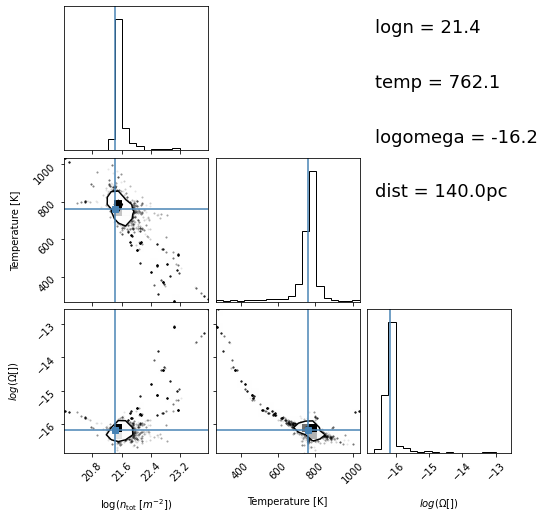

In [3]:
fig = corner.corner(postsamples, labels=[ r"$\log(n_\mathrm{tot}$ $[m^{-2}])$",r"Temperature [K]", "$log(\Omega [])$"], truths=[params[0], params[1], params[2]])


fig.text(.7,0.9,'logn = '+str(round(params[0],1)),fontsize=18)
fig.text(.7,0.8,'temp = '+str(round(params[1],1)),fontsize=18)
fig.text(.7,0.7,'logomega = '+str(round(params[2],1)),fontsize=18)
fig.text(.7,0.6,'dist = '+str(round(params[3],1))+'pc',fontsize=18)

synthdata


ValueError: invalid literal for int() with base 10: '<h'

### Run on minimum necessary arguments

In [2]:
data=pickle.load(open('fztau_fluxes.p','rb'))

del(data['wn'],data['a'],data['elower'],data['gup'], data['glow'],data['nu'],data['eup_k'])
del(data['wave'],data['Qup'],data['Qlow'],data['linewidth'],data['linewidth_err'],data['v_dop_fit'],data['v_dop_fit_err'],data['continuum'],data['continuum_err'])


data

molec_id,local_iso_id,Vp_HITRAN,Vpp_HITRAN,Qp_HITRAN,Qpp_HITRAN,Vup,Vlow,lineflux,lineflux_err
,,,,,,,,W / m2,W / m2
int32,int32,bytes15,bytes15,bytes15,bytes15,float64,float64,float64,float64
5,1,1,0,,P 9,1.0,0.0,1.316994343354751e-16,7.825901269238242e-17
5,1,1,0,,P 8,1.0,0.0,1.0323862164516226e-16,3.4120979639822254e-17
5,1,1,0,,P 7,1.0,0.0,9.367185275616444e-17,2.4365401504170184e-17
5,1,1,0,,P 6,1.0,0.0,9.465862409709585e-17,1.7634261314132918e-17
5,1,1,0,,P 5,1.0,0.0,6.893828434186451e-17,2.3441294346321396e-17
5,1,1,0,,P 3,1.0,0.0,8.537210549683167e-17,1.2019031142384293e-17
5,1,1,0,,P 2,1.0,0.0,6.987527727948783e-17,2.101648574489899e-17
5,1,1,0,,R 0,1.0,0.0,2.743133787053756e-17,2.151658840947691e-17


In [3]:
fz_tau_samples = rot_mcmc(data, plot=False)

78
81
84
87
90
96
100
109
112


## Maximum Likelihood best-fit

In [30]:
lognguess = 22
tguess = 750
logomegaguess = -16.5


myrun = sf_run(data, 4.648,5.018)

print(myrun.molec_id==data['molec_id'])
print(myrun.local_iso_id==data['local_iso_id'])
print(myrun.Vp_HITRAN==data['Vp_HITRAN'])
print(myrun.Vpp_HITRAN==data['Vpp_HITRAN'])
print(myrun.)


func = lambda *args: -loglikelihood(*args)

thetaguess = np.array([lognguess, tguess, logomegaguess])

MLE = minimize(func, thetaguess, args=(myrun.lineflux, myrun.lineflux_err, myrun))

print(MLE)

fig = corner.corner(fz_tau_samples, labels=[ r"$\log(n_\mathrm{tot}$ $[m^{-2}])$",r"Temperature [K]", "$log(\Omega)$"], truths=MLE['x'],label_kwargs={"fontsize": 15})
for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=12)
    
#fig.savefig('MLE.eps')

78
81
84
87
90
96
100
109
112
[ True  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True]


AttributeError: 'sf_run' object has no attribute 'Vp_HITRAN'

## Best fit parameters with error bars

In [ ]:
from IPython.display import display, Math
labels=[ r"log(Ntot)",r"Temperature", "Omega"]
for i in range(3):
    mcmc = np.percentile(postsamples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

## Plot of best fit

In [ ]:
bestfit=[np.percentile(postsamples[:,i],50) for i in range(3)]
modelflux=compute_fluxes(myrun, bestfit[0],bestfit[1],10**(bestfit[2]))
rotdiag=make_rotation_diagram(data,modelfluxes=modelflux)

fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(rotdiag['x'],rotdiag['y'],'ro',label='Data')
ax1.plot(rotdiag['x'],rotdiag['modely'],'bo',label='Model')
ax1.plot(rotdiag['x'],rotdiag['modely'],'b',label='_None_')
ax1.set_xlabel('Upper Level Energy [Kelvin]')
ax1.legend()

## Plot of some random samples

NameError: name 'postsamples' is not defined

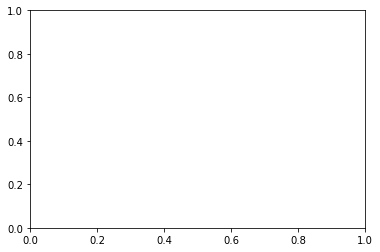

In [7]:

fig=plt.figure()
ax1=fig.add_subplot(111)
inds = np.random.randint(len(postsamples), size=100)
for ind in inds:
    sampley = postsamples[ind]
    modelflux=compute_fluxes(myrun, sampley[0],sampley[1],10.**sampley[2])
    rotdiag=make_rotation_diagram(data,modelfluxes=modelflux)
    ax1.plot(rotdiag['x'],rotdiag['modely'],alpha=0.2)
ax1.set_xlabel('Upper Level Energy [Kelvin]')

bestfit=[np.percentile(postsamples[:,i],50) for i in range(3)]
modelflux=compute_fluxes(myrun, bestfit[0],bestfit[1],10**(bestfit[2]))
rotdiag=make_rotation_diagram(data,modelfluxes=modelflux)
ax1.plot(rotdiag['x'],rotdiag['y'],'ro',label='Data')